In [48]:
import numpy as np
import matplotlib.pyplot as plt
from rbergomi.fbm.fbm_process import FBMProcess
from rbergomi.models.rbergomi import rBergomi  # Import rBergomi
from rbergomi.utils.utils import bsinv  # Black-Scholes inversion for IV calculation

In [49]:
# Vectorize Black-Scholes inversion function
vec_bsinv = np.vectorize(bsinv)

# ✅ Simulation parameters
n = 100     # Steps per year
m = 30000    # Number of paths (Large for accuracy)
T = 1.0       # Maturity
H = 0.4      # Hurst parameter
a = H - 0.5   # Alpha parameter
rho = -0.9    # Correlation between price and variance process
xi = 0.235**2  # Initial variance level
eta = 1.9      # Volatility of variance process

In [50]:
fbm_simulator = FBMProcess(method = "cholesky", n=n, T=T, H=H, m = m)

# ✅ Initialize rBergomi model
rB = rBergomi(fbm_simulator, n=n, m=m, T=T, a=a)

V = rB.V()
dB = rB.dB()

S = rB.S(V,dB)

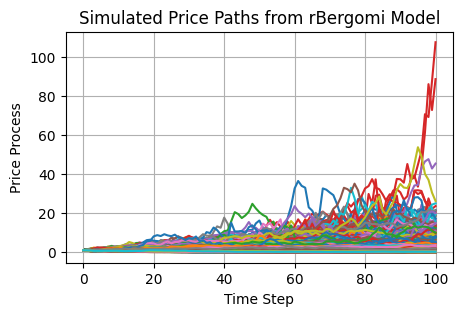

In [51]:
plt.figure(figsize=(5,3))
for s in S:
    plt.plot(s)
plt.xlabel("Time Step")
plt.ylabel("Price Process")
plt.title("Simulated Price Paths from rBergomi Model")
plt.grid(True)
plt.show()

0.9988978804316997


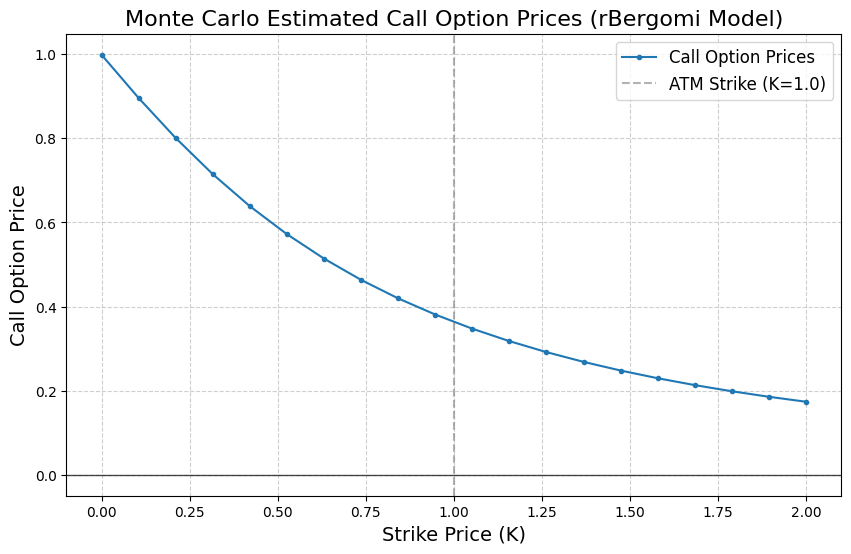

In [52]:
r = 0
K_values = np.linspace(0,2, 20)  # Strike range from 0.5 to 1.5
ST = S[:, -1]  # Last column of S (final prices at maturity)
print(np.mean(ST))
call_prices = [np.mean(np.maximum(ST - K, 0)) * np.exp(-r * T) for K in K_values]

# Improved plot with better formatting
plt.figure(figsize=(10, 6))

# Plot the call option prices
plt.plot(K_values, call_prices, linestyle='-', marker='.', markersize=6, label="Call Option Prices")

# Add labels, title, and grid
plt.xlabel("Strike Price (K)", fontsize=14)
plt.ylabel("Call Option Price", fontsize=14)
plt.title("Monte Carlo Estimated Call Option Prices (rBergomi Model)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.axhline(y=0, color="black", linewidth=1, alpha=0.7)  # X-axis line
plt.axvline(x=1.0, color="gray", linestyle="--", alpha=0.6, label="ATM Strike (K=1.0)")  # Highlight ATM strike

# Add legend
plt.legend(fontsize=12)
plt.show()

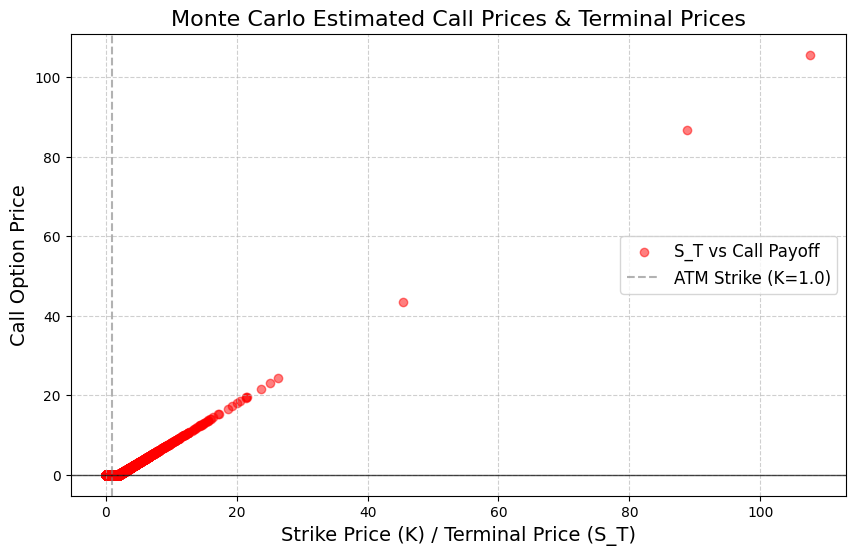

In [53]:
# Improved plot with better formatting to show S_T vs Call Prices
plt.figure(figsize=(10, 6))

# Scatter plot of terminal prices (S_T) vs call prices
plt.scatter(ST, np.maximum(ST - K_values[-1], 0), color='red', alpha=0.5, label="S_T vs Call Payoff")

# Add labels, title, and grid
plt.xlabel("Strike Price (K) / Terminal Price (S_T)", fontsize=14)
plt.ylabel("Call Option Price", fontsize=14)
plt.title("Monte Carlo Estimated Call Prices & Terminal Prices", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.axhline(y=0, color="black", linewidth=1, alpha=0.7)  # X-axis line
plt.axvline(x=1.0, color="gray", linestyle="--", alpha=0.6, label="ATM Strike (K=1.0)")  # Highlight ATM strike

# Add legend
plt.legend(fontsize=12)
plt.show()

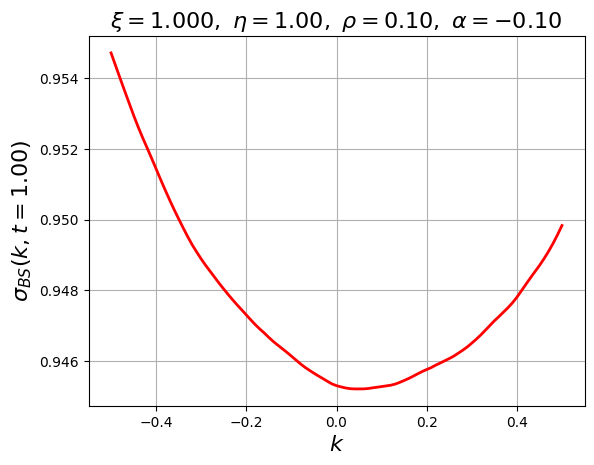

In [54]:
k = np.arange(-0.5, 0.51, 0.01)

ST = S[:,-1][:,np.newaxis]
K = np.exp(k)[np.newaxis,:]
call_payoffs = np.maximum(ST - K,0)
call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
implied_vols = vec_bsinv(call_prices, 1., np.transpose(K), rB.T)

plot, axes = plt.subplots()
axes.plot(k,implied_vols, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)